This notebook illustrates experiments using baseline models built on purpose.

# Imports

We will use the following libraries:
- **Pandas**: a data manipulation & analysis library ([documentation](https://pandas.pydata.org/docs/reference/index.html)) - *for efficient data reading/manipulation*
- **Spacy**: a modern NLP library ([documentation](https://spacy.io/api)) - *for base preprocessing such as tokenization*
- **Scikit-learn**: a machine learning library ([documentation](https://scikit-learn.org/stable/modules/classes.html)) - *for data splitting, feature extraction, model building, and evaluation*
- **Matplotlib**: a visualization library ([documentation](https://matplotlib.org/stable/api/index.html)) - *for making plots about our data*
- Other standard python libraries such as **re** ([documentation](https://docs.python.org/3/library/re.html)) - *for matching sensible data for anonymization*

In [1]:
# Install spacy and the associated Italian model
!pip install -U spacy
!python -m spacy download it_core_news_sm

# Import the needed libraries (and their functions)
import matplotlib.pyplot as plt
import pandas as pd
import re
import spacy
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, plot_confusion_matrix
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from spacy.language import Language
from spacy.matcher import Matcher

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/explosion/spacy-models/releases/download/it_core_news_sm-3.3.0/it_core_news_sm-3.3.0-py3-none-any.whl (13.0 MB)
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')


# Load the dataset

First, we define where our data splits are located.

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Define the filepath to your dataset splits
TRAIN_FILEPATHS = [
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/train-it_1.tsv",
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/train-it_2.tsv",
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/train-it_3.tsv",
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/train-it_4.tsv",
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/train-it_5.tsv"]
TEST_FILEPATHS = [
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/test-it_1.tsv",
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/test-it_2.tsv",
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/test-it_3.tsv",
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/test-it_4.tsv",
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/test-it_5.tsv"]

Then, we load these data splits and append them to dedicated lists to ease their subsequent retrieval.

In [4]:
K_SPLITS = 5    # define the number of files/iterations for k-fold cross-validation
train_sets = [] # initialize a list that will contain the training sets
test_sets = []  # initialize a list that will contain the test sets

# Load the K_SPLITS (tab-separated: \t) data splits into pandas dataframes,
# then add them to the respective train/test sets lists
for i in range(K_SPLITS):
  curr_train_set = pd.read_csv(TRAIN_FILEPATHS[i], delimiter='\t', names=["label", "tweet"])
  curr_test_set = pd.read_csv(TEST_FILEPATHS[i], delimiter='\t', names=["label", "tweet"])
  train_sets.append(curr_train_set)
  test_sets.append(curr_test_set)

# Preprocess the dataset

Our data is already preprocessed (e.g., anonymization; see notebook *1_preprocessing-it.ipynb*).

However, we will work on tokens as our units of linguistic information. To do that, we need to tokenize the text.

In [5]:
# First, define the functions and classes that we need to do that

# 1) Function that creates the merger of placeholder tokens component
@Language.factory("placeholder_merger")
def create_placeholder_merger(nlp, name):
  return PlaceholderMerger(nlp.vocab)

# 2) Actual definition of the placeholder merger component
class PlaceholderMerger:
  def __init__(self, vocab):
    # Define a pattern matcher (to merge "[", "USER"/"URL", "]" into a single token)
    patterns = [
      [{"ORTH": "["}, {"ORTH": "USER"}, {"ORTH": "]"}],
      [{"ORTH": "["}, {"ORTH": "URL"}, {"ORTH": "]"}],
    ]
    self.matcher = Matcher(vocab)
    self.matcher.add("PlaceholderMerger", patterns)

  def __call__(self, doc):
    matches = self.matcher(doc)
    spans = []
    for match_id, start, end in matches:
      spans.append(doc[start:end])
    with doc.retokenize() as retokenizer:
      for span in spans:
        retokenizer.merge(span)
    return doc

# 3) Define the function that will retrieve tokens
def get_tokenized_tweet(text):
  doc = nlp(text) # create a doc object for the raw text of the tweet

  # Iterate over the tokens adding them to a "tokens" list
  tokens = []
  for token in doc:
    tokens.append(token.text)
  return tokens

# Load the spacy model for Italian and add placeholder merger component
nlp = spacy.load("it_core_news_sm")
nlp.add_pipe("placeholder_merger", last=True)

# Iterate through the splits to preprocess them
for i in range(K_SPLITS):
  # Do the actual tokenization on the "tweet" column of the dataframe
  # Store the results on the "tweet_tokens" column
  train_sets[i]['tweet_tokens'] = list(map(get_tokenized_tweet, train_sets[i].tweet))
  test_sets[i]['tweet_tokens'] = list(map(get_tokenized_tweet, test_sets[i].tweet))
  
train_sets[0].head(10)  # print the first 10 elements of the first training split just for seeing the data

# Note: if this snippet gives you an error, you have to reset and restart colab
# Top bar: "Runtime" -> "Restart runtime"

,label,tweet,tweet_tokens
0,NOT ABUSIVE,[USER] perché non ci parlabdel congo? l'ambasc...,"[[USER], perché, non, ci, parlabdel, congo, ?,..."
1,NOT ABUSIVE,"[USER] [USER] [USER] non vado in crisi, semmai...","[[USER], [USER], [USER], non, vado, in, crisi,..."
2,NOT ABUSIVE,"[USER] ciao gian, ho letto il tuo servizio, ed...","[[USER], ciao, gian, ,, ho, letto, il, tuo, se..."
3,NOT ABUSIVE,[USER] per gli ebrei gesù cristo non è il mess...,"[[USER], per, gli, ebrei, gesù, cristo, non, è..."
4,NOT ABUSIVE,[USER] [USER] [USER] [USER] [URL] #cartonimor...,"[[USER], [USER], [USER], [USER], [URL], , #, ..."
5,NOT ABUSIVE,[USER] vabbè allora tutti gli zingari rubano e...,"[[USER], vabbè, allora, tutti, gli, zingari, r..."
6,NOT ABUSIVE,[USER] [USER] [USER] [USER] [USER] #megalivese...,"[[USER], [USER], [USER], [USER], [USER], #, me..."
7,NOT ABUSIVE,[USER] [USER] la sa cos'è hamas..? e lo stato ...,"[[USER], [USER], la, sa, cos', è, hamas, .., ?..."
8,NOT ABUSIVE,"[USER] cose da vecchio testamento, roba del ti...","[[USER], cose, da, vecchio, testamento, ,, rob..."
9,NOT ABUSIVE,una coppia di cristiani in pakistan accusati d...,"[una, coppia, di, cristiani, in, pakistan, acc..."


# Explore the dataset

Getting into data before delving into more complex modeling decisions is crucial to understand what we are manipulating.

Summary statistics have already been computed when creating the splits (see notebook *1_preprocessing-it.ipynb*)

### Token-level statistics

Compute the vocabulary size (unique tokens) as well as statistics about length of tweets.

In [6]:
tokens = Counter()        # this stores the tokens and their count
token_lengths = []        # this stores the token lengths of all tweets

# Note: we will do the following twice: one for the train set, and one for the
# test set. This is because train+test will produce the results for the whole
# dataset (for simplicity, we use the first split (0), but other splits would
# produce exactly the same results - each train+test split has the same examples)

# rows (first element) are number of examples
tot_examples = train_sets[0].shape[0] + test_sets[0].shape[0]
print(f"Tot examples: {tot_examples}")

# TRAINING SET
# Iterate over all the training examples (all rows)
for index, row in train_sets[0].iterrows():
  curr_tweet = row["tweet"]               # get the "tweet" col of the current example
  curr_tokens = row["tweet_tokens"]       # get the "tweet_tokens" col of the current example
  token_lengths.append(len(curr_tokens))  # append the count of tokens to the lengths list

  # Iterate over each token of the i-th examples to store occurrences of tokens
  for curr_token in curr_tokens:
    curr_token = str(curr_token)
    if curr_token in tokens:
      tokens[curr_token] += 1
    else:
      tokens[curr_token] = 1

# TEST SET
# Iterate over all the test examples (all rows)
for index, row in test_sets[0].iterrows():
  curr_tweet = row["tweet"]               # get the "tweet" col of the current example
  curr_tokens = row["tweet_tokens"]       # get the "tweet_tokens" col of the current example
  token_lengths.append(len(curr_tokens))  # append the count of tokens to the lengths list

  # Iterate over each token of the i-th examples to store occurrences of tokens
  for curr_token in curr_tokens:
    curr_token = str(curr_token)
    if curr_token in tokens:
      tokens[curr_token] += 1
    else:
      tokens[curr_token] = 1

print(f"Vocabulary size: {len(tokens)}")
print(f"Min token length: {min(token_lengths)}")
print(f"Max token length: {max(token_lengths)}")
print(f"Avg token length: {round(sum(token_lengths)/tot_examples, 2)}")

Tot examples: 3000
Vocabulary size: 14731
Min token length: 2
Max token length: 102
Avg token length: 33.5


# Models

We will experiment with simple baselines and more elaborated models to compare performance and gauge the level of difficulty of our task.

We keep track of scores of all models on a dictionary, in order to easily plot/compare results at the end of this notebook.

In [7]:
# This variable will store the performance of all models
model_scores = dict()

## Always abusive baseline

Probably the most trivial one, this baseline always predict a tweet as abusive.

In [8]:
#Import metrics
from sklearn.metrics import recall_score, precision_score

# Initialize the results dictionary
model_scores["always-abusive"] = {}
model_scores["always-abusive"]["accuracy"] = {}
model_scores["always-abusive"]["macro_f1"] = {}
model_scores["always-abusive"]["recall"] = {}
model_scores["always-abusive"]["precision"] = {}

# Do the following K times (for all splits)
for j in range(K_SPLITS):
  # Generate a list of "ABUSIVE" predictions (the length must be the same of the number of test examples)
  predictions = []
  for i in range(test_sets[j].shape[0]):
    predictions.append("ABUSIVE")
  
  # Compare the predictions to the actual values on the test set and print results
  accuracy = accuracy_score(test_sets[j]["label"], predictions)
  macro_f1 = f1_score(test_sets[j]["label"], predictions, average='macro')
  precision = precision_score(test_sets[j]["label"], predictions, average='macro')
  recall = recall_score(test_sets[j]["label"], predictions, average='macro')

  # Print results for the current split
  print("Split", j+1)
  print("- Accuracy", accuracy)
  print("- Macro F1", macro_f1)
  print("- Precision", precision)
  print("- Recall", recall)

  print()

  # Add results to the results dictionary
  if len(model_scores["always-abusive"]["accuracy"]) == 0:
    model_scores["always-abusive"]["accuracy"] = [accuracy]
    model_scores["always-abusive"]["macro_f1"] = [macro_f1]
    model_scores["always-abusive"]["precision"] = [precision]
    model_scores["always-abusive"]["recall"] = [recall]

  else:
    model_scores["always-abusive"]["accuracy"].append(accuracy)
    model_scores["always-abusive"]["macro_f1"].append(macro_f1)
    model_scores["always-abusive"]["precision"].append(precision)
    model_scores["always-abusive"]["recall"].append(recall)


Split 1
- Accuracy 0.31666666666666665
- Macro F1 0.24050632911392406
- Precision 0.15833333333333333
- Recall 0.5

Split 2
- Accuracy 0.31833333333333336
- Macro F1 0.24146649810366627
- Precision 0.15916666666666668
- Recall 0.5

Split 3
- Accuracy 0.31833333333333336
- Macro F1 0.24146649810366627
- Precision 0.15916666666666668
- Recall 0.5

Split 4
- Accuracy 0.31833333333333336
- Macro F1 0.24146649810366627
- Precision 0.15916666666666668
- Recall 0.5

Split 5
- Accuracy 0.31833333333333336
- Macro F1 0.24146649810366627
- Precision 0.15916666666666668
- Recall 0.5



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

## Always not abusive baseline

Similarly to the previous one, this baseline always predict a tweet as not abusive.

In [9]:
# Initialize the results dictionary
model_scores["always-not-abusive"] = {}
model_scores["always-not-abusive"]["accuracy"] = {}
model_scores["always-not-abusive"]["macro_f1"] = {}
model_scores["always-not-abusive"]["precision"] = {}
model_scores["always-not-abusive"]["recall"] = {}


# Do the following K times (for all splits)
for j in range(K_SPLITS):
  # Generate a list of "NOT-ABUSIVE" predictions (the length must be the same of the number of test examples)
  predictions = []
  for i in range(test_sets[j].shape[0]):
    predictions.append("NOT ABUSIVE")

  # Compare the predictions to the actual values on the test set and print results
  accuracy = accuracy_score(test_sets[j]["label"], predictions)
  macro_f1 = f1_score(test_sets[j]["label"], predictions, average='macro')
  precision = precision_score(test_sets[j]["label"], predictions, average='macro')
  recall = recall_score(test_sets[j]["label"], predictions, average='macro')


  # Print results for the current split
  print("Split", j+1)
  print("- Accuracy", accuracy)
  print("- Macro F1", macro_f1)
  print("- Precision", precision)
  print("- Recall", recall)

  print()

  # Add results to the results dictionary
  if len(model_scores["always-not-abusive"]["accuracy"]) == 0:
    model_scores["always-not-abusive"]["accuracy"] = [accuracy]
    model_scores["always-not-abusive"]["macro_f1"] = [macro_f1]
    model_scores["always-not-abusive"]["precision"] = [precision]
    model_scores["always-not-abusive"]["recall"] = [recall]

  else:
    model_scores["always-not-abusive"]["accuracy"].append(accuracy)
    model_scores["always-not-abusive"]["macro_f1"].append(macro_f1)
    model_scores["always-not-abusive"]["precision"].append(precision)
    model_scores["always-not-abusive"]["recall"].append(recall)


Split 1
- Accuracy 0.6833333333333333
- Macro F1 0.40594059405940597
- Precision 0.3416666666666667
- Recall 0.5

Split 2
- Accuracy 0.6816666666666666
- Macro F1 0.4053518334985134
- Precision 0.3408333333333333
- Recall 0.5

Split 3
- Accuracy 0.6816666666666666
- Macro F1 0.4053518334985134
- Precision 0.3408333333333333
- Recall 0.5

Split 4
- Accuracy 0.6816666666666666
- Macro F1 0.4053518334985134
- Precision 0.3408333333333333
- Recall 0.5

Split 5
- Accuracy 0.6816666666666666
- Macro F1 0.4053518334985134
- Precision 0.3408333333333333
- Recall 0.5



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

## Random baseline

A random baseline simply predict a labels (drawn from a predefined set) at random. 

This baseline represents a good starting point to determine if more complex models actually learn something about the task.

In [10]:
import random     # import the standard library for pseudorandom number generators
random.seed(42)   # ensures you will get the same results if you run this code twice or more times

# Initialize the results dictionary
model_scores["random"] = {}
model_scores["random"]["accuracy"] = {}
model_scores["random"]["macro_f1"] = {}
model_scores["random"]["precision"] = {}
model_scores["random"]["recall"] = {}

# Do the following K times (for all splits)
for j in range(K_SPLITS):
  # Generate a list of 0,1 values (the length must be the same of the number of test examples)
  # These will be used as predictions for the elements on the test set
  raw_predictions = []
  for i in range(test_sets[j].shape[0]):
    raw_predictions.append(random.randint(0,1))

  # Convert them to our labels (1 -> ABUS; 0 -> NOT-ABUSIVE)
  predictions = ["ABUSIVE" if p==1 else "NOT ABUSIVE" for p in raw_predictions]

  # Compare the predictions to the actual values on the test set and print results
  accuracy = accuracy_score(test_sets[j]["label"], predictions)
  macro_f1 = f1_score(test_sets[j]["label"], predictions, average='macro')
  precision = precision_score(test_sets[j]["label"], predictions, average='macro')
  recall = recall_score(test_sets[j]["label"], predictions, average='macro')

  # Print results for the current split
  print("Split", j+1)
  print("- Accuracy", accuracy)
  print("- Macro F1", macro_f1)
  print("- Precision", precision)
  print("- Recall", recall)

  print()

  # Add results to the results dictionary
  if len(model_scores["random"]["accuracy"]) == 0:
    model_scores["random"]["accuracy"] = [accuracy]
    model_scores["random"]["macro_f1"] = [macro_f1]
    model_scores["random"]["precision"] = [precision]
    model_scores["random"]["recall"] = [recall]

  else:
    model_scores["random"]["accuracy"].append(accuracy)
    model_scores["random"]["macro_f1"].append(macro_f1)
    model_scores["random"]["precision"].append(precision)
    model_scores["random"]["recall"].append(recall)


Split 1
- Accuracy 0.5166666666666667
- Macro F1 0.49789925666004897
- Precision 0.5130052020808323
- Recall 0.5150192554557125

Split 2
- Accuracy 0.4533333333333333
- Macro F1 0.44075021312872975
- Precision 0.4646972857796272
- Recall 0.4594912889309899

Split 3
- Accuracy 0.4583333333333333
- Macro F1 0.44614702950190155
- Precision 0.4703125
- Recall 0.4659493849127613

Split 4
- Accuracy 0.45166666666666666
- Macro F1 0.43632049206308415
- Precision 0.45767519466073414
- Recall 0.45129225924551003

Split 5
- Accuracy 0.51
- Macro F1 0.4873940788785438
- Precision 0.49970460701586206
- Recall 0.49966077394743913



## Logistic regression

Logistic regression is a supervised machine learning algorithm for classification. 

We here extract features, implement the model, and evaluate it.

### Feature extraction

Computers understand numbers, but we are actually working with words. 

We need to convert our texts to numbers, and use derived **features** (e.g., tokens) in our model.

Indeed, differently from previous baselines, here we will use the training set to extract features and "train" a model to identify hate speech.

As typical convention, X represents inputs (e.g., representations of tweets) and y represents outputs (e.g., labels).

In [11]:
# Prepare lists for training and test tweets and labels
# There will be K objects for each list, since we have K splits
X_training = []
X_test = []
y_training = []
y_test = []

# Do the following K times (for all splits)
for j in range(K_SPLITS):
  # Create a list of lists for each set.
  # Inner lists are tokens corresponding to the i-th tweet
  training_data_tokens = [x for x in train_sets[j]["tweet_tokens"]]
  test_data_tokens = [x for x in test_sets[j]["tweet_tokens"]]

  # Convert tweets to a matrix of token counts
  # These will serve as our features
  vectorizer = CountVectorizer(
      binary=True,
      tokenizer=lambda x: x,    # override tokenizer (we already have tokens)
      preprocessor=lambda x: x  # override preprocessor (we already preprocessed our data)
  )

  # Fit to training data, then transform it (standardization by centering and scaling)
  # The standardization applies to test set too (no fitting there)
  X_training.append(vectorizer.fit_transform(training_data_tokens))
  X_test.append(vectorizer.transform(test_data_tokens))

  # Get the list of labels for each set
  y_training.append(train_sets[j]['label'])
  y_test.append(test_sets[j]['label'])

### Training, prediction and analysis

Now that we defined our features, we need to fit the model using training data.

We can then use our model to predict unseen data (the test set) and compute performance scores.

Split 1
- Accuracy 0.75
- Macro F1 0.6899801587301586
- Precision 0.7116649568523323
- Recall 0.6801026957637998



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


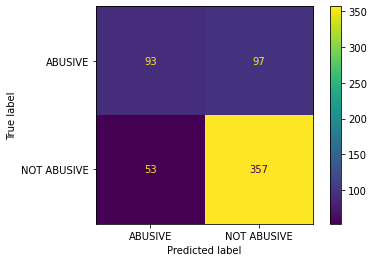

Split 2
- Accuracy 0.7516666666666667
- Macro F1 0.6891937463278623
- Precision 0.716304347826087
- Recall 0.6783176947989605



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


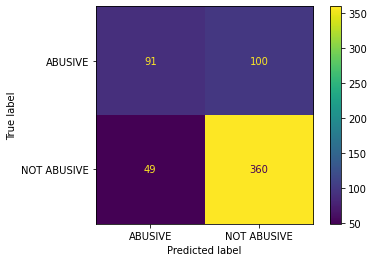

Split 3
- Accuracy 0.75
- Macro F1 0.6778165988888253
- Precision 0.7183157894736842
- Recall 0.6659327436347111



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


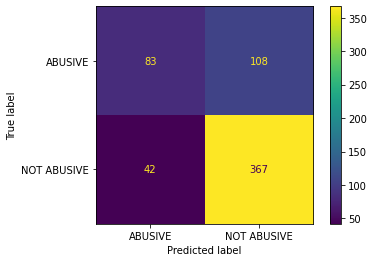

Split 4
- Accuracy 0.7266666666666667
- Macro F1 0.6585420021098216
- Precision 0.6813146062207389
- Recall 0.6502131363688731



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


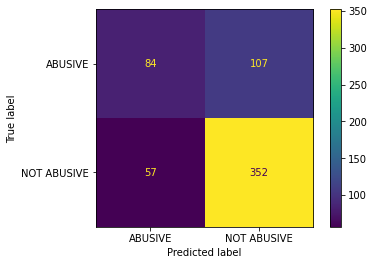

Split 5
- Accuracy 0.72
- Macro F1 0.6448503297818365
- Precision 0.6722480720001287
- Recall 0.6369513178612117



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


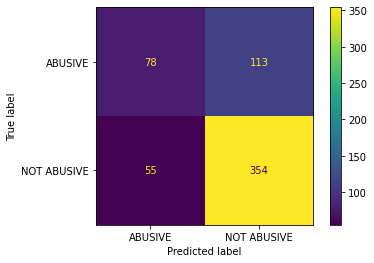

In [12]:
# Initialize the results dictionary
model_scores["logistic-regression"] = {}
model_scores["logistic-regression"]["accuracy"] = {}
model_scores["logistic-regression"]["macro_f1"] = {}
model_scores["logistic-regression"]["precision"] = {}
model_scores["logistic-regression"]["recall"] = {}


# Do the following K times (for all splits)
for j in range(K_SPLITS):
  # Fit the model according to the given training data
  # Namely, using training X and y
  model = LogisticRegression().fit(X_training[j], y_training[j])

  # Make predictions on test data using the fitted model
  y_pred = model.predict(X_test[j])

  # Compare the predictions to the actual values on the test set and print results
  accuracy = accuracy_score(y_test[j], y_pred)
  macro_f1 = f1_score(y_test[j], y_pred, average='macro')
  precision = precision_score(y_test[j], y_pred, average='macro')
  recall = recall_score(y_test[j], y_pred, average='macro')


  # Print results for the current split
  print("Split", j+1)
  print("- Accuracy", accuracy)
  print("- Macro F1", macro_f1)
  print("- Precision", precision)
  print("- Recall", recall)

  print()

  # Plot a confusion matrix for the fitted model
  plot_confusion_matrix(model, X_test[j], y_test[j])  
  plt.show()

  # Add results to the results dictionary
  if len(model_scores["logistic-regression"]["accuracy"]) == 0:
    model_scores["logistic-regression"]["accuracy"] = [accuracy]
    model_scores["logistic-regression"]["macro_f1"] = [macro_f1]
    model_scores["logistic-regression"]["precision"] = [precision]
    model_scores["logistic-regression"]["recall"] = [recall]

  else:
    model_scores["logistic-regression"]["accuracy"].append(accuracy)
    model_scores["logistic-regression"]["macro_f1"].append(macro_f1)
    model_scores["logistic-regression"]["precision"].append(precision)
    model_scores["logistic-regression"]["recall"].append(recall)


### Most important features

In [13]:
# Define the function that will return the top features learnt by the model
def extract_features(model, vectorizer):
  ranked_features = []
  coeff = model.coef_[0]
  id_to_token = {}

  for key, value in vectorizer.vocabulary_.items():
    id_to_token[value] = key

  tuples = []
  for i in range(len(coeff)):
    tuples.append((id_to_token[i], coeff[i]))
  tuples.sort(key=lambda x: -x[1])

  for tup in tuples:
    ranked_features.append(tup)

  return ranked_features

# Get the coefficients of each feature
ranked_features = extract_features(model, vectorizer)
ranked_features = ranked_features[::-1]

# Print the top 50 features
for i in range(50):
  print(f"{ranked_features[i][1]}\t{ranked_features[i][0]}")

-1.6245515426428843	cazzo
-1.3860949120769788	bergoglio
-1.2490414259233436	🤡
-1.2416306647341244	fascisti
-1.2218783555953725	islamica
-1.2095276956028533	invasione
-1.184094127506035	mica
-1.1273930917283939	voi
-1.1177098868929407	merda
-1.0937722049674452	schifo
-1.0795430143214784	sionisti
-1.0506325707985371	💩
-1.0351693949054477	quelli
-1.032050434338792	papa
-1.016711157196183	islamici
-1.0020148869855392	dittatura
-0.9926053139648914	vaccinati
-0.9704692724469506	draghi
-0.9611967522273422	islam
-0.956726123356542	continua
-0.936953058137225	teocratico
-0.9151986608904037	qualcuno
-0.9144364732382713	là
-0.9082594998257267	rispetto
-0.905952142505108	destra
-0.8821548537405735	!
-0.8801609102998516	un'
-0.8681759477313649	pseudosinistra
-0.8680271713030588	cinesi
-0.8662971094327307	maomettani
-0.8653947156189135	culo
-0.8629188063864869	potere
-0.8606807789668905	strage
-0.8401829737634087	medioevo
-0.8333058572771452	siete
-0.8295895154680301	criminali
-0.8286056089211878	oc

## Multinomial Naive Bayes

Split  1
- Accuracy: 0.755
- MacroF1: 0.6696319880138589
- Precision: 0.7352092352092352
- Recall: 0.6569319640564827


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


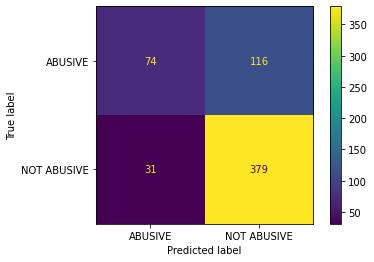

Split  2
- Accuracy: 0.745
- MacroF1: 0.6577066344508204
- Precision: 0.7191772973798793
- Recall: 0.646916883216631


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


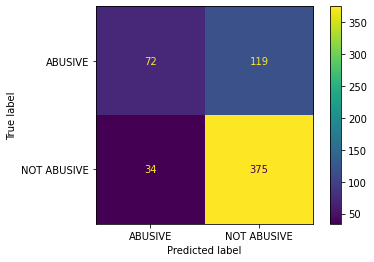

Split  3
- Accuracy: 0.7416666666666667
- MacroF1: 0.6343980343980344
- Precision: 0.7302048726467332
- Recall: 0.6277282095264916


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


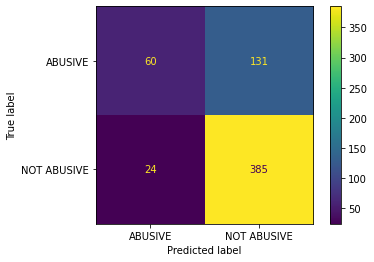

Split  4
- Accuracy: 0.74
- MacroF1: 0.6502033006457786
- Precision: 0.711111111111111
- Recall: 0.6404587872348596


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


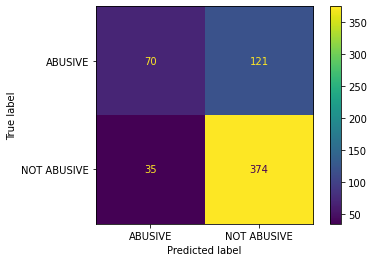

Split  5
- Accuracy: 0.7416666666666667
- MacroF1: 0.6467625598699478
- Precision: 0.71833075859826
- Recall: 0.6374953596436206


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


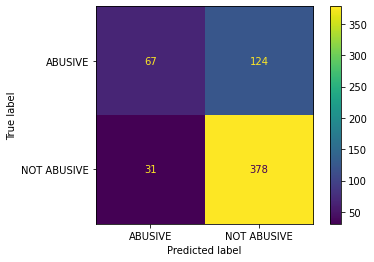

In [14]:
#Import the model
from sklearn.naive_bayes import MultinomialNB

#Initialization of dictionary for metrics' results
model_scores["multinomial-naive-bayes"] = {}
model_scores["multinomial-naive-bayes"]["accuracy"] = {}
model_scores["multinomial-naive-bayes"]["macro_f1"] = {}
model_scores["multinomial-naive-bayes"]["precision"] = {}
model_scores["multinomial-naive-bayes"]["recall"] = {}

#Fit the model to each split
for j in range(K_SPLITS):
  model = MultinomialNB().fit(X_training[j], y_training[j])

  #Obtain predictions
  y_pred = model.predict(X_test[j])

  #Make comparisons to actual values
  accuracy = accuracy_score(y_test[j], y_pred)
  macro_f1 = f1_score(y_test[j], y_pred, average="macro")
  precision = precision_score(y_test[j], y_pred, average="macro")
  recall = recall_score(y_test[j], y_pred, average="macro")

  #Print the metrics' results for each split
  print("Split ", j+1)
  print(f"- Accuracy: {accuracy}")
  print(f"- MacroF1: {macro_f1}")
  print(f"- Precision: {precision}")
  print(f"- Recall: {recall}")

  #Plot a confusion matrix for errors visualization
  plot_confusion_matrix(model, X_test[j], y_test[j])  
  plt.show()

  # Add results to the results dictionary
  if len(model_scores["multinomial-naive-bayes"]["accuracy"]) == 0:
    model_scores["multinomial-naive-bayes"]["accuracy"] = [accuracy]
    model_scores["multinomial-naive-bayes"]["macro_f1"] = [macro_f1]
    model_scores["multinomial-naive-bayes"]["precision"] = [precision]
    model_scores["multinomial-naive-bayes"]["recall"] = [recall]
  else:
    model_scores["multinomial-naive-bayes"]["accuracy"].append(accuracy)
    model_scores["multinomial-naive-bayes"]["macro_f1"].append(macro_f1)
    model_scores["multinomial-naive-bayes"]["precision"].append(precision)
    model_scores["multinomial-naive-bayes"]["recall"].append(recall)



## Linear Support Vector Machine 

Split  1
- Accuracy: 0.7166666666666667
- MacroF1: 0.6582868782161235
- Precision: 0.6678504989007272
- Recall: 0.6528883183568678


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


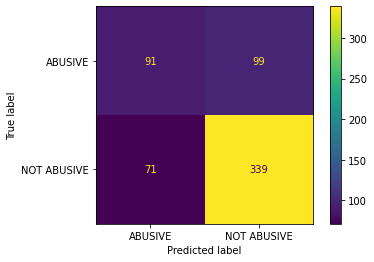

Split  2
- Accuracy: 0.7416666666666667
- MacroF1: 0.6899741645137094
- Precision: 0.7005202506153502
- Recall: 0.6835404959100859


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


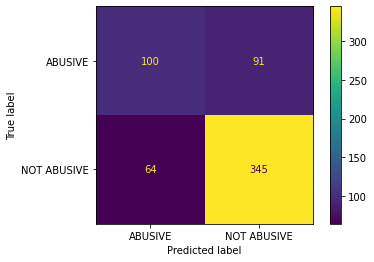

Split  3
- Accuracy: 0.7183333333333334
- MacroF1: 0.6550445482410334
- Precision: 0.6701127819548872
- Recall: 0.6482865884099899


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


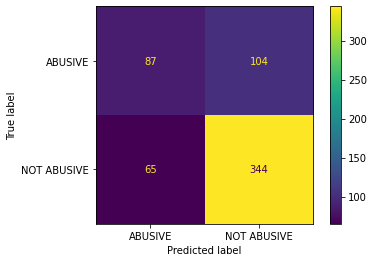

Split  4
- Accuracy: 0.7333333333333333
- MacroF1: 0.6804941690185846
- Precision: 0.6900731452455591
- Recall: 0.6746374121532533


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


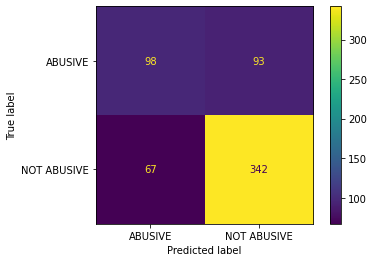

Split  5
- Accuracy: 0.695
- MacroF1: 0.627765064836003
- Precision: 0.6396686273367888
- Recall: 0.6227998310270229


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


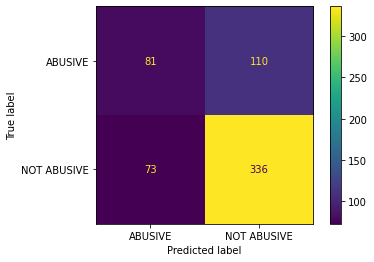

In [15]:
#Import the model
from sklearn.svm import LinearSVC

#Initialization of dictionary for metrics' results
model_scores["linear-svc"] = {}
model_scores["linear-svc"]["accuracy"] = {}
model_scores["linear-svc"]["macro_f1"] = {}
model_scores["linear-svc"]["precision"] = {}
model_scores["linear-svc"]["recall"] = {}

#Fit the model to each split
for j in range(K_SPLITS):
  model = LinearSVC().fit(X_training[j], y_training[j])

  #Obtain predictions
  y_pred = model.predict(X_test[j])

  #Make comparisons to actual values
  accuracy = accuracy_score(y_test[j], y_pred)
  macro_f1 = f1_score(y_test[j], y_pred, average="macro")
  precision = precision_score(y_test[j], y_pred, average="macro")
  recall = recall_score(y_test[j], y_pred, average="macro")


  #Print the metrics' results for each split
  print("Split ", j+1)
  print(f"- Accuracy: {accuracy}")
  print(f"- MacroF1: {macro_f1}")
  print(f"- Precision: {precision}")
  print(f"- Recall: {recall}")


  #Plot a confusion matrix for errors visualization
  plot_confusion_matrix(model, X_test[j], y_test[j])  
  plt.show()

  # Add results to the results dictionary
  if len(model_scores["linear-svc"]["accuracy"]) == 0:
    model_scores["linear-svc"]["accuracy"] = [accuracy]
    model_scores["linear-svc"]["macro_f1"] = [macro_f1]
    model_scores["linear-svc"]["precision"] = [precision]
    model_scores["linear-svc"]["recall"] = [recall]

  else:
    model_scores["linear-svc"]["accuracy"].append(accuracy)
    model_scores["linear-svc"]["macro_f1"].append(macro_f1)
    model_scores["linear-svc"]["precision"].append(precision)
    model_scores["linear-svc"]["recall"].append(recall)


## Decision Tree Classifier

Split  1
- Accuracy: 0.6683333333333333
- MacroF1: 0.600656875959477
- Precision: 0.6069057011694347
- Recall: 0.5977535301668806


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


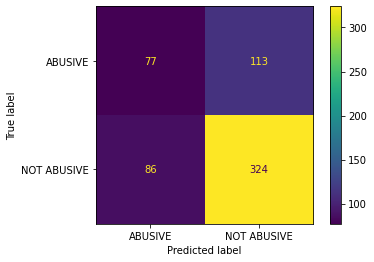

Split  2
- Accuracy: 0.6583333333333333
- MacroF1: 0.5938972328883811
- Precision: 0.598016415868673
- Recall: 0.5917190440225809


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


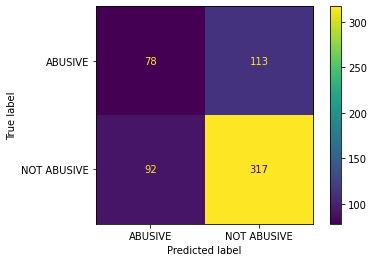

Split  3
- Accuracy: 0.6766666666666666
- MacroF1: 0.5945663531870429
- Precision: 0.6111986766335304
- Recall: 0.5912134051895186


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


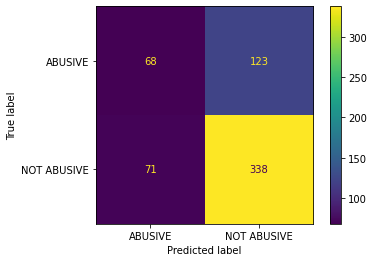

Split  4
- Accuracy: 0.6566666666666666
- MacroF1: 0.5859240994854203
- Precision: 0.5923117191810864
- Recall: 0.5835200143371011


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


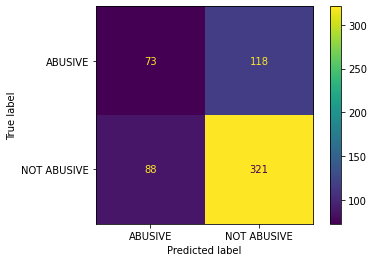

Split  5
- Accuracy: 0.6566666666666666
- MacroF1: 0.5886362426114278
- Precision: 0.5939393939393939
- Recall: 0.5863106286562808


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


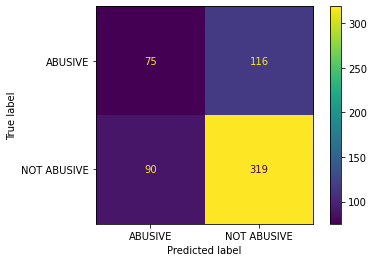

In [16]:
#Import the model
from sklearn.tree import DecisionTreeClassifier as clf

#Initialization of dictionary for metrics' results
model_scores["decision-tree"] = {}
model_scores["decision-tree"]["accuracy"] = {}
model_scores["decision-tree"]["macro_f1"] = {}
model_scores["decision-tree"]["precision"] = {}
model_scores["decision-tree"]["recall"] = {}


#Fit the model to each split
for j in range(K_SPLITS):
  model = clf().fit(X_training[j], y_training[j])

  #Obtain predictions
  y_pred = model.predict(X_test[j])

  #Make comparisons to actual values
  accuracy = accuracy_score(y_test[j], y_pred)
  macro_f1 = f1_score(y_test[j], y_pred, average="macro")
  precision = precision_score(y_test[j], y_pred, average="macro")
  recall = recall_score(y_test[j], y_pred, average="macro")


  #Print the metrics' results for each split
  print("Split ", j+1)
  print(f"- Accuracy: {accuracy}")
  print(f"- MacroF1: {macro_f1}")
  print(f"- Precision: {precision}")
  print(f"- Recall: {recall}")


  #Plot a confusion matrix for errors visualization
  plot_confusion_matrix(model, X_test[j], y_test[j])  
  plt.show()

  # Add results to the results dictionary
  if len(model_scores["decision-tree"]["accuracy"]) == 0:
    model_scores["decision-tree"]["accuracy"] = [accuracy]
    model_scores["decision-tree"]["macro_f1"] = [macro_f1]
    model_scores["decision-tree"]["precision"] = [precision]
    model_scores["decision-tree"]["recall"] = [recall]

  else:
    model_scores["decision-tree"]["accuracy"].append(accuracy)
    model_scores["decision-tree"]["macro_f1"].append(macro_f1)
    model_scores["decision-tree"]["precision"].append(precision)
    model_scores["decision-tree"]["recall"].append(recall)


# Models comparison

Here we compare the performance of the diverse classifiers we experimented with.

In [17]:
# Create dictionaries per metric
accuracy_dict = dict()
macro_f1_dict = dict()
precision_dict = dict()
recall_dict = dict()

for name, value in model_scores.items():
  accuracy_dict[name] = value["accuracy"]
  macro_f1_dict[name] = value["macro_f1"]
  precision_dict[name] = value["precision"]
  recall_dict[name] = value["recall"]

#Calculate average performance for each method and their deviation standard. Then, print the results

import numpy as np

# Accuracy means and standard deviations
means_accuracy = dict()
stand_dev_accuracy = dict()

for key in accuracy_dict:
  means_accuracy[key] = sum(accuracy_dict[key]) / len(accuracy_dict[key])
for key in accuracy_dict:
  stand_dev_accuracy[key] = np.std(accuracy_dict[key])

print("Accuracy Mean:")
for key, value in means_accuracy.items():
  print(key, value, end="\n")
print("\n")

print("Accuracy Deviation Standard:")
for key, value in stand_dev_accuracy.items():
  print(key, value, end="\n")
print("\n")

# Macro f1 means and standard deviations
means_macro_f1 = dict()
stand_dev_macro_f1 = dict()

for key in macro_f1_dict:
  means_macro_f1[key] = sum(macro_f1_dict[key]) / len(macro_f1_dict[key])
for key in macro_f1_dict:
  stand_dev_macro_f1[key] = np.std(macro_f1_dict[key])

print("Macro F1 Mean")
for key, value in means_macro_f1.items():
  print(key, value, end="\n")
print("\n")

print("Macro F1 Deviation Standard")
for key, value in stand_dev_macro_f1.items():
  print(key, value, end="\n")
print("\n")

#Precision means and standard deviation
means_precision = dict()
stand_dev_precision = dict()

for key in precision_dict:
  means_precision[key] = sum(precision_dict[key]) / len(precision_dict[key])
for key in precision_dict:
  stand_dev_precision[key] = np.std(precision_dict[key])

print("Precision Mean")
for key, value in means_precision.items():
  print(key, value, end="\n")
print("\n")

print("Precision Deviation Standard")
for key, value in stand_dev_precision.items():
  print(key, value, end="\n")
print("\n")

#Recall means and standard deviation
means_recall = dict()
stand_dev_recall = dict()

for key in recall_dict:
  means_recall[key] = sum(recall_dict[key]) / len(recall_dict[key])
for key in recall_dict:
  stand_dev_recall[key] = np.std(recall_dict[key])

print("Recall Mean")
for key, value in means_recall.items():
  print(key, value, end="\n")
print("\n")

print("Recall Deviation Standard")
for key, value in stand_dev_recall.items():
  print(key, value, end="\n")
print("\n")

Accuracy Mean:
always-abusive 0.318
always-not-abusive 0.682
random 0.4779999999999999
logistic-regression 0.7396666666666667
multinomial-naive-bayes 0.7446666666666666
linear-svc 0.721
decision-tree 0.6633333333333333


Accuracy Deviation Standard:
always-abusive 0.000666666666666682
always-not-abusive 0.000666666666666682
random 0.029009576962712794
logistic-regression 0.013515423288475539
multinomial-naive-bayes 0.005416025603090637
linear-svc 0.016006942938057305
decision-tree 0.007958224257542222


Macro F1 Mean
always-abusive 0.2412744643057178
always-not-abusive 0.4054695856106919
random 0.4617022140464616
logistic-regression 0.6720765671677009
multinomial-naive-bayes 0.651740503475688
linear-svc 0.6623129649650907
decision-tree 0.5927361608263497


Macro F1 Deviation Standard
always-abusive 0.00038406759589688645
always-not-abusive 0.00023550422435703042
random 0.025672864008650317
logistic-regression 0.017725331200817047
multinomial-naive-bayes 0.011692767735516047
linear-svc 

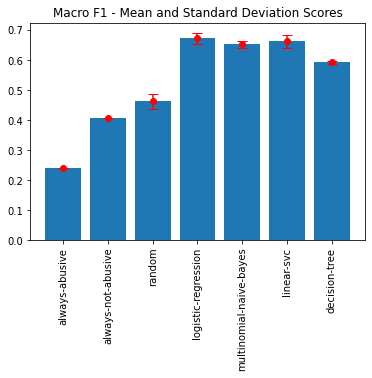

In [18]:
# Plot the macro f1 scores
plt.title("Macro F1 - Mean and Standard Deviation Scores")
plt.bar(range(len(means_macro_f1)), list(means_macro_f1.values()), align='center')
plt.errorbar(range(len(means_macro_f1)), list(means_macro_f1.values()), yerr=stand_dev_macro_f1.values(), capsize=5, fmt="o", color="r")
plt.xticks(range(len(means_macro_f1)), list(means_macro_f1.keys()))
plt.xticks(rotation = 90)
plt.show()